In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import copy
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Custom libraries
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
#EXTERNAL_LIBS_PATH = os.path.join(base_dir, 'libs')
#sys.path.insert(1, EXTERNAL_LIBS_PATH)
import libs.model_interpretability as model_inter

In [2]:
tf.__version__

'2.5.0'

In [3]:
# if GPU memory is not enough, then make GPU not available (train using the CPU)
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#physical_devices = tf.config.list_physical_devices('GPU')
#print('Physical GPU Devices: {}'.format(physical_devices))

In [4]:
# GPU stuff
physical_devices = tf.config.list_physical_devices('GPU')
print('Physical Devices: {}'.format(physical_devices))
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU memory limitated successfuly!')
except:
    print('Warning! GPU memory could not be limitated!')

Physical Devices: []
Warning! GPU memory could not be limitated!


In [5]:
%ls Data

test/  train/


In [26]:
base_dir = %pwd
data_dir = os.path.join(base_dir, 'Data')
model_path = os.path.join(base_dir, 'Model')
BATCH_SIZE = 16
IMG_SIZE = 256
input_shape = (IMG_SIZE,IMG_SIZE)
seed = 123
# For reproducibility
#np.random.seed(seed)
#train_frac = 0.8
elu_alpha = 1.0

In [7]:
input_shape

(256, 256)

## 0. Load Data

In [8]:
# set images generatos (to load images from disk)
image_gen = ImageDataGenerator(rescale=1./255)

sample_data = image_gen.flow_from_directory(
    directory=os.path.join(data_dir,'train'),
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)

Found 2856 images belonging to 87 classes.


In [9]:
n_classes = sample_data.num_classes

In [10]:
#generate name-label_number pairs 
class_indices = sample_data.class_indices
class_indices

{'Alexandrite': 0,
 'Almandine': 1,
 'Amazonite': 2,
 'Amber': 3,
 'Amethyst': 4,
 'Ametrine': 5,
 'Andalusite': 6,
 'Andradite': 7,
 'Aquamarine': 8,
 'Aventurine Green': 9,
 'Aventurine Yellow': 10,
 'Benitoite': 11,
 'Beryl Golden': 12,
 'Bixbite': 13,
 'Bloodstone': 14,
 'Blue Lace Agate': 15,
 'Carnelian': 16,
 'Cats Eye': 17,
 'Chalcedony': 18,
 'Chalcedony Blue': 19,
 'Chrome Diopside': 20,
 'Chrysoberyl': 21,
 'Chrysocolla': 22,
 'Chrysoprase': 23,
 'Citrine': 24,
 'Coral': 25,
 'Danburite': 26,
 'Diamond': 27,
 'Diaspore': 28,
 'Dumortierite': 29,
 'Emerald': 30,
 'Fluorite': 31,
 'Garnet Red': 32,
 'Goshenite': 33,
 'Grossular': 34,
 'Hessonite': 35,
 'Hiddenite': 36,
 'Iolite': 37,
 'Jade': 38,
 'Jasper': 39,
 'Kunzite': 40,
 'Kyanite': 41,
 'Labradorite': 42,
 'Lapis Lazuli': 43,
 'Larimar': 44,
 'Malachite': 45,
 'Moonstone': 46,
 'Morganite': 47,
 'Onyx Black': 48,
 'Onyx Green': 49,
 'Onyx Red': 50,
 'Opal': 51,
 'Pearl': 52,
 'Peridot': 53,
 'Prehnite': 54,
 'Pyrite': 5

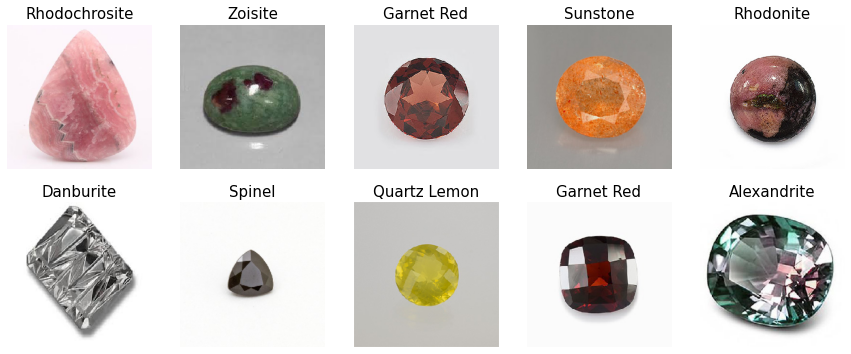

In [11]:
def plot_image(img):
    plt.imshow(img)
    plt.axis('off')

images, labels = sample_data[0]
sample_size = 10
plt.figure(figsize=(15,6))
for i in range(sample_size):
    class_id = np.argmax(labels[i])
    style_name = [key for key in class_indices if class_indices[key] == class_id][0]
    
    plt.subplot(2,5,i+1)
    plot_image(images[i])
    plt.title(style_name, fontsize=15)

In [12]:
temp_df = pd.DataFrame({'class': sample_data.classes}).value_counts().reset_index().sort_values(by='class')
#temp_df['class_name'] = 
temp_df.columns = ['class', 'counts']


Number of images:  2856


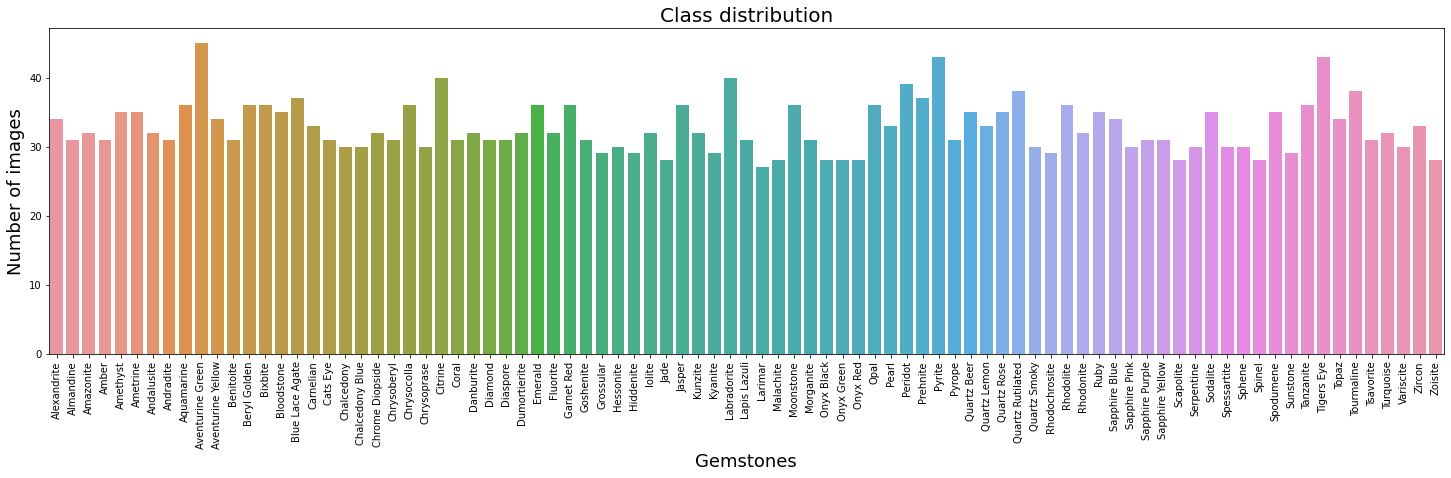

In [13]:
# how many images do we have per class?
plt.figure(figsize=(25,6))
sns.barplot(data=temp_df,
            x='class',
            y='counts')
plt.ylabel('Number of images', fontsize=18)
plt.xlabel('Gemstones', fontsize=18)
plt.title('Class distribution', fontsize=20)
plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

print('Number of images: ', np.sum(temp_df['counts'].values))

## Set train and validation set

In [14]:
# set data augmentation techniques
image_gen_w_augmentation = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=90,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                              )

In [15]:
train_data = image_gen_w_augmentation.flow_from_directory(
    directory=os.path.join(data_dir,'train'),
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)

val_data = image_gen.flow_from_directory(
    directory=os.path.join(data_dir,'test'),
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)

Found 2856 images belonging to 87 classes.
Found 363 images belonging to 87 classes.


In [16]:
class_indices = train_data.class_indices
class_indices

#TODO: validate that the class indices between train and val data are the same

{'Alexandrite': 0,
 'Almandine': 1,
 'Amazonite': 2,
 'Amber': 3,
 'Amethyst': 4,
 'Ametrine': 5,
 'Andalusite': 6,
 'Andradite': 7,
 'Aquamarine': 8,
 'Aventurine Green': 9,
 'Aventurine Yellow': 10,
 'Benitoite': 11,
 'Beryl Golden': 12,
 'Bixbite': 13,
 'Bloodstone': 14,
 'Blue Lace Agate': 15,
 'Carnelian': 16,
 'Cats Eye': 17,
 'Chalcedony': 18,
 'Chalcedony Blue': 19,
 'Chrome Diopside': 20,
 'Chrysoberyl': 21,
 'Chrysocolla': 22,
 'Chrysoprase': 23,
 'Citrine': 24,
 'Coral': 25,
 'Danburite': 26,
 'Diamond': 27,
 'Diaspore': 28,
 'Dumortierite': 29,
 'Emerald': 30,
 'Fluorite': 31,
 'Garnet Red': 32,
 'Goshenite': 33,
 'Grossular': 34,
 'Hessonite': 35,
 'Hiddenite': 36,
 'Iolite': 37,
 'Jade': 38,
 'Jasper': 39,
 'Kunzite': 40,
 'Kyanite': 41,
 'Labradorite': 42,
 'Lapis Lazuli': 43,
 'Larimar': 44,
 'Malachite': 45,
 'Moonstone': 46,
 'Morganite': 47,
 'Onyx Black': 48,
 'Onyx Green': 49,
 'Onyx Red': 50,
 'Opal': 51,
 'Pearl': 52,
 'Peridot': 53,
 'Prehnite': 54,
 'Pyrite': 5

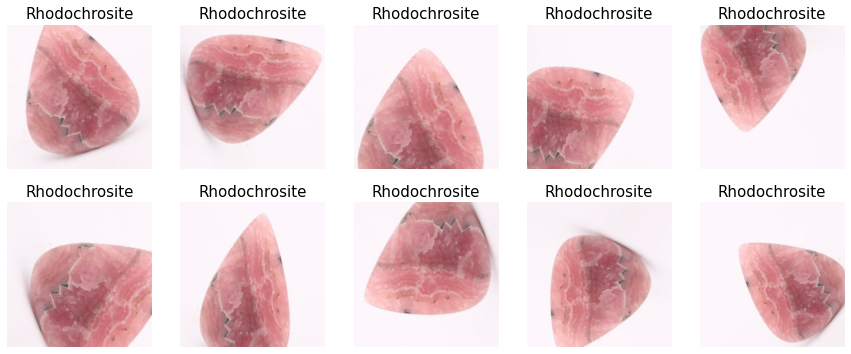

In [17]:
# take a look to an augmented image 
sample_size = 10
plt.figure(figsize=(15,6))
for i in range(sample_size):
    images, labels = train_data[0]
    class_id = np.argmax(labels[0])
    style_name = [key for key in class_indices if class_indices[key] == class_id][0]
    
    plt.subplot(2,5,i+1)
    plot_image(images[0])
    plt.title(style_name, fontsize=15)

# Model

In [18]:
def Resblock2D_v2(x, kernel_size, out_filters, strides, dilation_rate, elu_alpha, name):
    fx = tf.keras.layers.BatchNormalization(name=name+'bn1')(x)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act1')(fx)
    fx = tf.keras.layers.Conv2D(out_filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate, name=name+'conv2')(fx)
    fx = tf.keras.layers.BatchNormalization(name=name+'bn2')(fx)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act2')(fx)
    fx = tf.keras.layers.Conv2D(out_filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate, name=name+'conv3')(fx)
    out = tf.keras.layers.Add(name=name+'add')([x,fx])
    return out

def Resblock1D_v2(x, n_units, elu_alpha, name):
    fx = tf.keras.layers.BatchNormalization(name=name+'bn1')(x)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act1')(fx)
    fx = tf.keras.layers.Dense(n_units, name=name+'dense2')(fx)
    fx = tf.keras.layers.BatchNormalization(name=name+'bn2')(fx)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act2')(fx)
    fx = tf.keras.layers.Dense(n_units, name=name+'dense3')(fx)
    out = tf.keras.layers.Add(name=name+'add')([x,fx])
    return out

def Custom_model(input_shape, n_calsses, elu_alpha):
    
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    
    # increase dim
    x = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='valid', input_shape=input_shape, name='block1_conv1')(input_layer)
    # resblock
    x = Resblock2D_v2(x, kernel_size=(3,3), out_filters=32, strides=(1,1), dilation_rate=(1,1), elu_alpha=elu_alpha, name='block1_')
    
    filters = [64, 128, 256]
    for block_num, n_filters in enumerate(filters, 2):
        # pre bn and act
        block_name = 'block'+str(block_num)+'_'
        x = tf.keras.layers.BatchNormalization(name=block_name+'pre_bn')(x)
        x = tf.keras.layers.ELU(alpha=elu_alpha, name=block_name+'pre_act')(x)
        # decrease img size
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name=block_name+'maxpool')(x)
        # increase dim
        x = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', input_shape=input_shape, name=block_name+'conv1')(x)
        # resblock
        x = Resblock2D_v2(x, kernel_size=(3,3), out_filters=n_filters, strides=(1,1), dilation_rate=(1,1), elu_alpha=elu_alpha, name=block_name)

    # Prediction layers
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization(name='pre_global_avg_pool_bn')(x)
    x = tf.keras.layers.ELU(alpha=elu_alpha, name='pre_global_avg_pool_act')(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    #x = tf.keras.layers.Flatten()(x)
    
    # Dense layer
    block_num += 1
    block_name = 'block'+str(block_num)+'_'
    x = tf.keras.layers.Dense(256, name=block_name+'dense1')(x)
    # Residual block
    x = Resblock1D_v2(x, n_units=256, elu_alpha=elu_alpha, name=block_name)
    
    # Output layer
    x = tf.keras.layers.BatchNormalization(name='pre_output_bn')(x)
    x = tf.keras.layers.ELU(alpha=elu_alpha, name='pre_output_act')(x)
    x = tf.keras.layers.Dense(n_calsses)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name='Custom_model')

In [19]:
model = Custom_model(list(input_shape)+[3], n_classes, elu_alpha)

In [20]:
model.summary()

Model: "Custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
block1_bn1 (BatchNormalization) (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_act1 (ELU)               (None, 127, 127, 32) 0           block1_bn1[0][0]                 
_______________________________________________________________________________________

In [21]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

# Set callbacks to save best model and early stopping

In [22]:
callbacks = []

# Save best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    verbose=0, 
    save_best_only=True,
    save_weights_only=False, 
    mode='min', 
    save_freq='epoch'
)
callbacks.append(checkpoint_cb)

# Early stopping
earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=30, 
    verbose=0,
    mode='min'
)
callbacks.append(earlystopping_cb)

In [23]:
epochs=150
history = model.fit(
    train_data,
    steps_per_epoch=int(np.ceil(train_data.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data,
    validation_steps=int(np.ceil(val_data.n / float(BATCH_SIZE))),
    callbacks=callbacks
)

Epoch 1/150
179/179 [==============================] - 40s 190ms/step - loss: 3.5588 - accuracy: 0.1176 - val_loss: 5.3262 - val_accuracy: 0.0386


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 2/150
179/179 [==============================] - 33s 181ms/step - loss: 2.9474 - accuracy: 0.1873 - val_loss: 5.6119 - val_accuracy: 0.0689
Epoch 3/150
179/179 [==============================] - 32s 179ms/step - loss: 2.6905 - accuracy: 0.2272 - val_loss: 3.2587 - val_accuracy: 0.1791


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 4/150
179/179 [==============================] - 32s 180ms/step - loss: 2.5523 - accuracy: 0.2651 - val_loss: 3.5490 - val_accuracy: 0.1901
Epoch 5/150
179/179 [==============================] - 32s 180ms/step - loss: 2.4088 - accuracy: 0.2871 - val_loss: 2.4291 - val_accuracy: 0.3003


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 6/150
179/179 [==============================] - 32s 179ms/step - loss: 2.3001 - accuracy: 0.3176 - val_loss: 3.6540 - val_accuracy: 0.1653
Epoch 7/150
179/179 [==============================] - 32s 178ms/step - loss: 2.2582 - accuracy: 0.3246 - val_loss: 2.3747 - val_accuracy: 0.3168


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 8/150
179/179 [==============================] - 32s 180ms/step - loss: 2.1863 - accuracy: 0.3410 - val_loss: 2.0501 - val_accuracy: 0.3829


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 9/150
179/179 [==============================] - 32s 180ms/step - loss: 2.0459 - accuracy: 0.3820 - val_loss: 2.8962 - val_accuracy: 0.2149
Epoch 10/150
179/179 [==============================] - 32s 181ms/step - loss: 2.0231 - accuracy: 0.3806 - val_loss: 2.2594 - val_accuracy: 0.3361
Epoch 11/150
179/179 [==============================] - 32s 179ms/step - loss: 1.9775 - accuracy: 0.3810 - val_loss: 1.8589 - val_accuracy: 0.4380


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 12/150
179/179 [==============================] - 32s 179ms/step - loss: 1.8392 - accuracy: 0.4230 - val_loss: 1.9194 - val_accuracy: 0.4160
Epoch 13/150
179/179 [==============================] - 32s 180ms/step - loss: 1.9072 - accuracy: 0.4023 - val_loss: 1.9226 - val_accuracy: 0.4242
Epoch 14/150
179/179 [==============================] - 32s 179ms/step - loss: 1.7848 - accuracy: 0.4506 - val_loss: 2.4074 - val_accuracy: 0.3030
Epoch 15/150
179/179 [==============================] - 32s 181ms/step - loss: 1.7513 - accuracy: 0.4412 - val_loss: 2.1517 - val_accuracy: 0.3857
Epoch 16/150
179/179 [==============================] - 32s 180ms/step - loss: 1.7251 - accuracy: 0.4513 - val_loss: 2.0438 - val_accuracy: 0.3747
Epoch 17/150
179/179 [==============================] - 32s 179ms/step - loss: 1.6878 - accuracy: 0.4629 - val_loss: 2.0035 - val_accuracy: 0.3939
Epoch 18/150
179/17

/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 19/150
179/179 [==============================] - 32s 178ms/step - loss: 1.6295 - accuracy: 0.4839 - val_loss: 1.9270 - val_accuracy: 0.4160
Epoch 20/150
179/179 [==============================] - 32s 178ms/step - loss: 1.5733 - accuracy: 0.4989 - val_loss: 1.8317 - val_accuracy: 0.4187
Epoch 21/150
179/179 [==============================] - 32s 180ms/step - loss: 1.5165 - accuracy: 0.5175 - val_loss: 1.7680 - val_accuracy: 0.4380
Epoch 22/150
179/179 [==============================] - 32s 179ms/step - loss: 1.5157 - accuracy: 0.5091 - val_loss: 2.0025 - val_accuracy: 0.4105
Epoch 23/150
179/179 [==============================] - 32s 179ms/step - loss: 1.4929 - accuracy: 0.5196 - val_loss: 1.6032 - val_accuracy: 0.4904


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 24/150
179/179 [==============================] - 32s 180ms/step - loss: 1.4754 - accuracy: 0.5214 - val_loss: 1.6328 - val_accuracy: 0.4766
Epoch 25/150
179/179 [==============================] - 32s 181ms/step - loss: 1.4057 - accuracy: 0.5441 - val_loss: 1.5314 - val_accuracy: 0.5179


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 26/150
179/179 [==============================] - 32s 179ms/step - loss: 1.4224 - accuracy: 0.5431 - val_loss: 1.5527 - val_accuracy: 0.4986
Epoch 27/150
179/179 [==============================] - 32s 177ms/step - loss: 1.3509 - accuracy: 0.5452 - val_loss: 1.8901 - val_accuracy: 0.4683
Epoch 28/150
179/179 [==============================] - 32s 180ms/step - loss: 1.3707 - accuracy: 0.5480 - val_loss: 1.6400 - val_accuracy: 0.5152
Epoch 29/150
179/179 [==============================] - 32s 181ms/step - loss: 1.3593 - accuracy: 0.5490 - val_loss: 2.6468 - val_accuracy: 0.3802
Epoch 30/150
179/179 [==============================] - 32s 180ms/step - loss: 1.2988 - accuracy: 0.5735 - val_loss: 2.0690 - val_accuracy: 0.4022
Epoch 31/150
179/179 [==============================] - 33s 182ms/step - loss: 1.2860 - accuracy: 0.5739 - val_loss: 1.2384 - val_accuracy: 0.5868


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 32/150
179/179 [==============================] - 33s 182ms/step - loss: 1.2664 - accuracy: 0.5644 - val_loss: 1.6401 - val_accuracy: 0.5014
Epoch 33/150
179/179 [==============================] - 33s 186ms/step - loss: 1.2639 - accuracy: 0.5802 - val_loss: 1.3840 - val_accuracy: 0.5813
Epoch 34/150
179/179 [==============================] - 33s 184ms/step - loss: 1.2146 - accuracy: 0.5994 - val_loss: 1.7742 - val_accuracy: 0.4711
Epoch 35/150
179/179 [==============================] - 33s 183ms/step - loss: 1.2036 - accuracy: 0.5907 - val_loss: 1.5950 - val_accuracy: 0.5124
Epoch 36/150
179/179 [==============================] - 33s 185ms/step - loss: 1.1831 - accuracy: 0.6124 - val_loss: 1.5110 - val_accuracy: 0.5813
Epoch 37/150
179/179 [==============================] - 35s 198ms/step - loss: 1.1576 - accuracy: 0.6257 - val_loss: 1.5972 - val_accuracy: 0.5096
Epoch 38/150
179/17

/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 41/150
179/179 [==============================] - 32s 179ms/step - loss: 1.1176 - accuracy: 0.6190 - val_loss: 1.5344 - val_accuracy: 0.5620
Epoch 42/150
179/179 [==============================] - 32s 181ms/step - loss: 1.1088 - accuracy: 0.6211 - val_loss: 1.3705 - val_accuracy: 0.5785
Epoch 43/150
179/179 [==============================] - 32s 178ms/step - loss: 1.1008 - accuracy: 0.6243 - val_loss: 1.6528 - val_accuracy: 0.5207
Epoch 44/150
179/179 [==============================] - 32s 179ms/step - loss: 1.0821 - accuracy: 0.6348 - val_loss: 1.2584 - val_accuracy: 0.6088
Epoch 45/150
179/179 [==============================] - 32s 178ms/step - loss: 1.0663 - accuracy: 0.6467 - val_loss: 1.2659 - val_accuracy: 0.6006
Epoch 46/150
179/179 [==============================] - 32s 178ms/step - loss: 1.0511 - accuracy: 0.6348 - val_loss: 1.2821 - val_accuracy: 0.5758
Epoch 47/150
179/17

/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 57/150
179/179 [==============================] - 32s 178ms/step - loss: 0.8949 - accuracy: 0.6887 - val_loss: 1.1705 - val_accuracy: 0.6501
INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 58/150
179/179 [==============================] - 32s 178ms/step - loss: 0.8973 - accuracy: 0.6978 - val_loss: 1.3133 - val_accuracy: 0.6143
Epoch 59/150
179/179 [==============================] - 32s 178ms/step - loss: 0.8829 - accuracy: 0.6957 - val_loss: 1.3618 - val_accuracy: 0.6006
Epoch 60/150
179/179 [==============================] - 32s 180ms/step - loss: 0.8771 - accuracy: 0.7006 - val_loss: 1.2480 - val_accuracy: 0.6253
Epoch 61/150
179/179 [==============================] - 32s 179ms/step - loss: 0.8590 - accuracy: 0.7027 - val_loss: 1.9898 - val_accuracy: 0.4766
Epoch 62/150
179/179 [==============================] - 32s 178ms/step - loss: 0.8880 - accuracy: 0.6863 - val_loss: 1.0611 - val_accuracy: 0.6612


/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 63/150
179/179 [==============================] - 32s 178ms/step - loss: 0.8519 - accuracy: 0.7013 - val_loss: 2.0166 - val_accuracy: 0.4766
Epoch 64/150
179/179 [==============================] - 32s 177ms/step - loss: 0.8447 - accuracy: 0.7076 - val_loss: 1.4124 - val_accuracy: 0.5372
Epoch 65/150
179/179 [==============================] - 32s 177ms/step - loss: 0.8717 - accuracy: 0.6971 - val_loss: 1.2286 - val_accuracy: 0.5950
Epoch 66/150
179/179 [==============================] - 32s 176ms/step - loss: 0.8284 - accuracy: 0.7045 - val_loss: 1.4610 - val_accuracy: 0.5647
Epoch 67/150
179/179 [==============================] - 32s 178ms/step - loss: 0.8138 - accuracy: 0.7073 - val_loss: 1.0954 - val_accuracy: 0.6749
Epoch 68/150
179/179 [==============================] - 32s 177ms/step - loss: 0.8193 - accuracy: 0.7195 - val_loss: 1.6635 - val_accuracy: 0.5179
Epoch 69/150
179/17

/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 80/150
179/179 [==============================] - 33s 183ms/step - loss: 0.7112 - accuracy: 0.7458 - val_loss: 1.1151 - val_accuracy: 0.6529
Epoch 81/150
179/179 [==============================] - 33s 184ms/step - loss: 0.6949 - accuracy: 0.7549 - val_loss: 1.2088 - val_accuracy: 0.6584
Epoch 82/150
179/179 [==============================] - 33s 186ms/step - loss: 0.7158 - accuracy: 0.7409 - val_loss: 1.2895 - val_accuracy: 0.6336
Epoch 83/150
179/179 [==============================] - 33s 181ms/step - loss: 0.7419 - accuracy: 0.7451 - val_loss: 1.5159 - val_accuracy: 0.5317
Epoch 84/150
179/179 [==============================] - 32s 181ms/step - loss: 0.7070 - accuracy: 0.7465 - val_loss: 1.6467 - val_accuracy: 0.5344
Epoch 85/150
179/179 [==============================] - 33s 184ms/step - loss: 0.7377 - accuracy: 0.7412 - val_loss: 1.0632 - val_accuracy: 0.6722
Epoch 86/150
179/17

/home/lorena/anaconda3/envs/architecture_env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /home/lorena/Documents/Personal_projects/Gemstones/Model/assets
Epoch 108/150
179/179 [==============================] - 32s 179ms/step - loss: 0.5741 - accuracy: 0.7875 - val_loss: 1.3699 - val_accuracy: 0.6364
Epoch 109/150
179/179 [==============================] - 32s 177ms/step - loss: 0.5484 - accuracy: 0.7896 - val_loss: 1.1654 - val_accuracy: 0.6639
Epoch 110/150
179/179 [==============================] - 32s 178ms/step - loss: 0.5327 - accuracy: 0.8060 - val_loss: 1.1317 - val_accuracy: 0.6887
Epoch 111/150
179/179 [==============================] - 32s 178ms/step - loss: 0.5702 - accuracy: 0.7980 - val_loss: 1.1049 - val_accuracy: 0.6777
Epoch 112/150
179/179 [==============================] - 32s 181ms/step - loss: 0.5615 - accuracy: 0.8053 - val_loss: 1.6353 - val_accuracy: 0.5702
Epoch 113/150
179/179 [==============================] - 33s 182ms/step - loss: 0.5217 - accuracy: 0.8141 - val_loss: 1.0436 - val_accuracy: 0.6915
Epoch 114/150

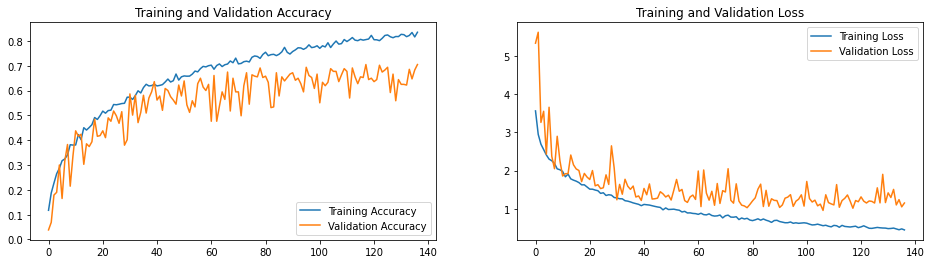

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
#LOAD the best model

try:
    del(model)
except:
    pass
model = tf.keras.models.load_model(model_path)

## Evaluate model performance

In [40]:
def plot_confusion_matrix(data_gen, title=''):
    n_batches = int(np.ceil(data_gen.n/BATCH_SIZE))
    classes_df = pd.DataFrame()

    for batch in np.arange(n_batches):
        classes = np.argmax(data_gen[batch][1], axis=1)
        temp_df = pd.DataFrame(classes)
        classes_df = classes_df.append(temp_df, ignore_index=True)
    classes_df.columns = ['true_class']

    #logits and probs
    logits = model.predict(data_gen)
    probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

    classes_df['predicted_class'] = np.argmax(probs, axis=1)
    
    conf_matrix = confusion_matrix(classes_df.true_class.values, 
                                    classes_df.predicted_class.values, 
                                    labels=np.arange(n_classes))
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
    
    plt.figure(figsize=(40,30))
    sns.heatmap(conf_matrix_norm, 
                cmap='viridis',
                annot=conf_matrix_norm,
                vmin=0, vmax=1,)
    _ = plt.title(title, fontsize=25)
    _ = plt.yticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=0)
    _ = plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

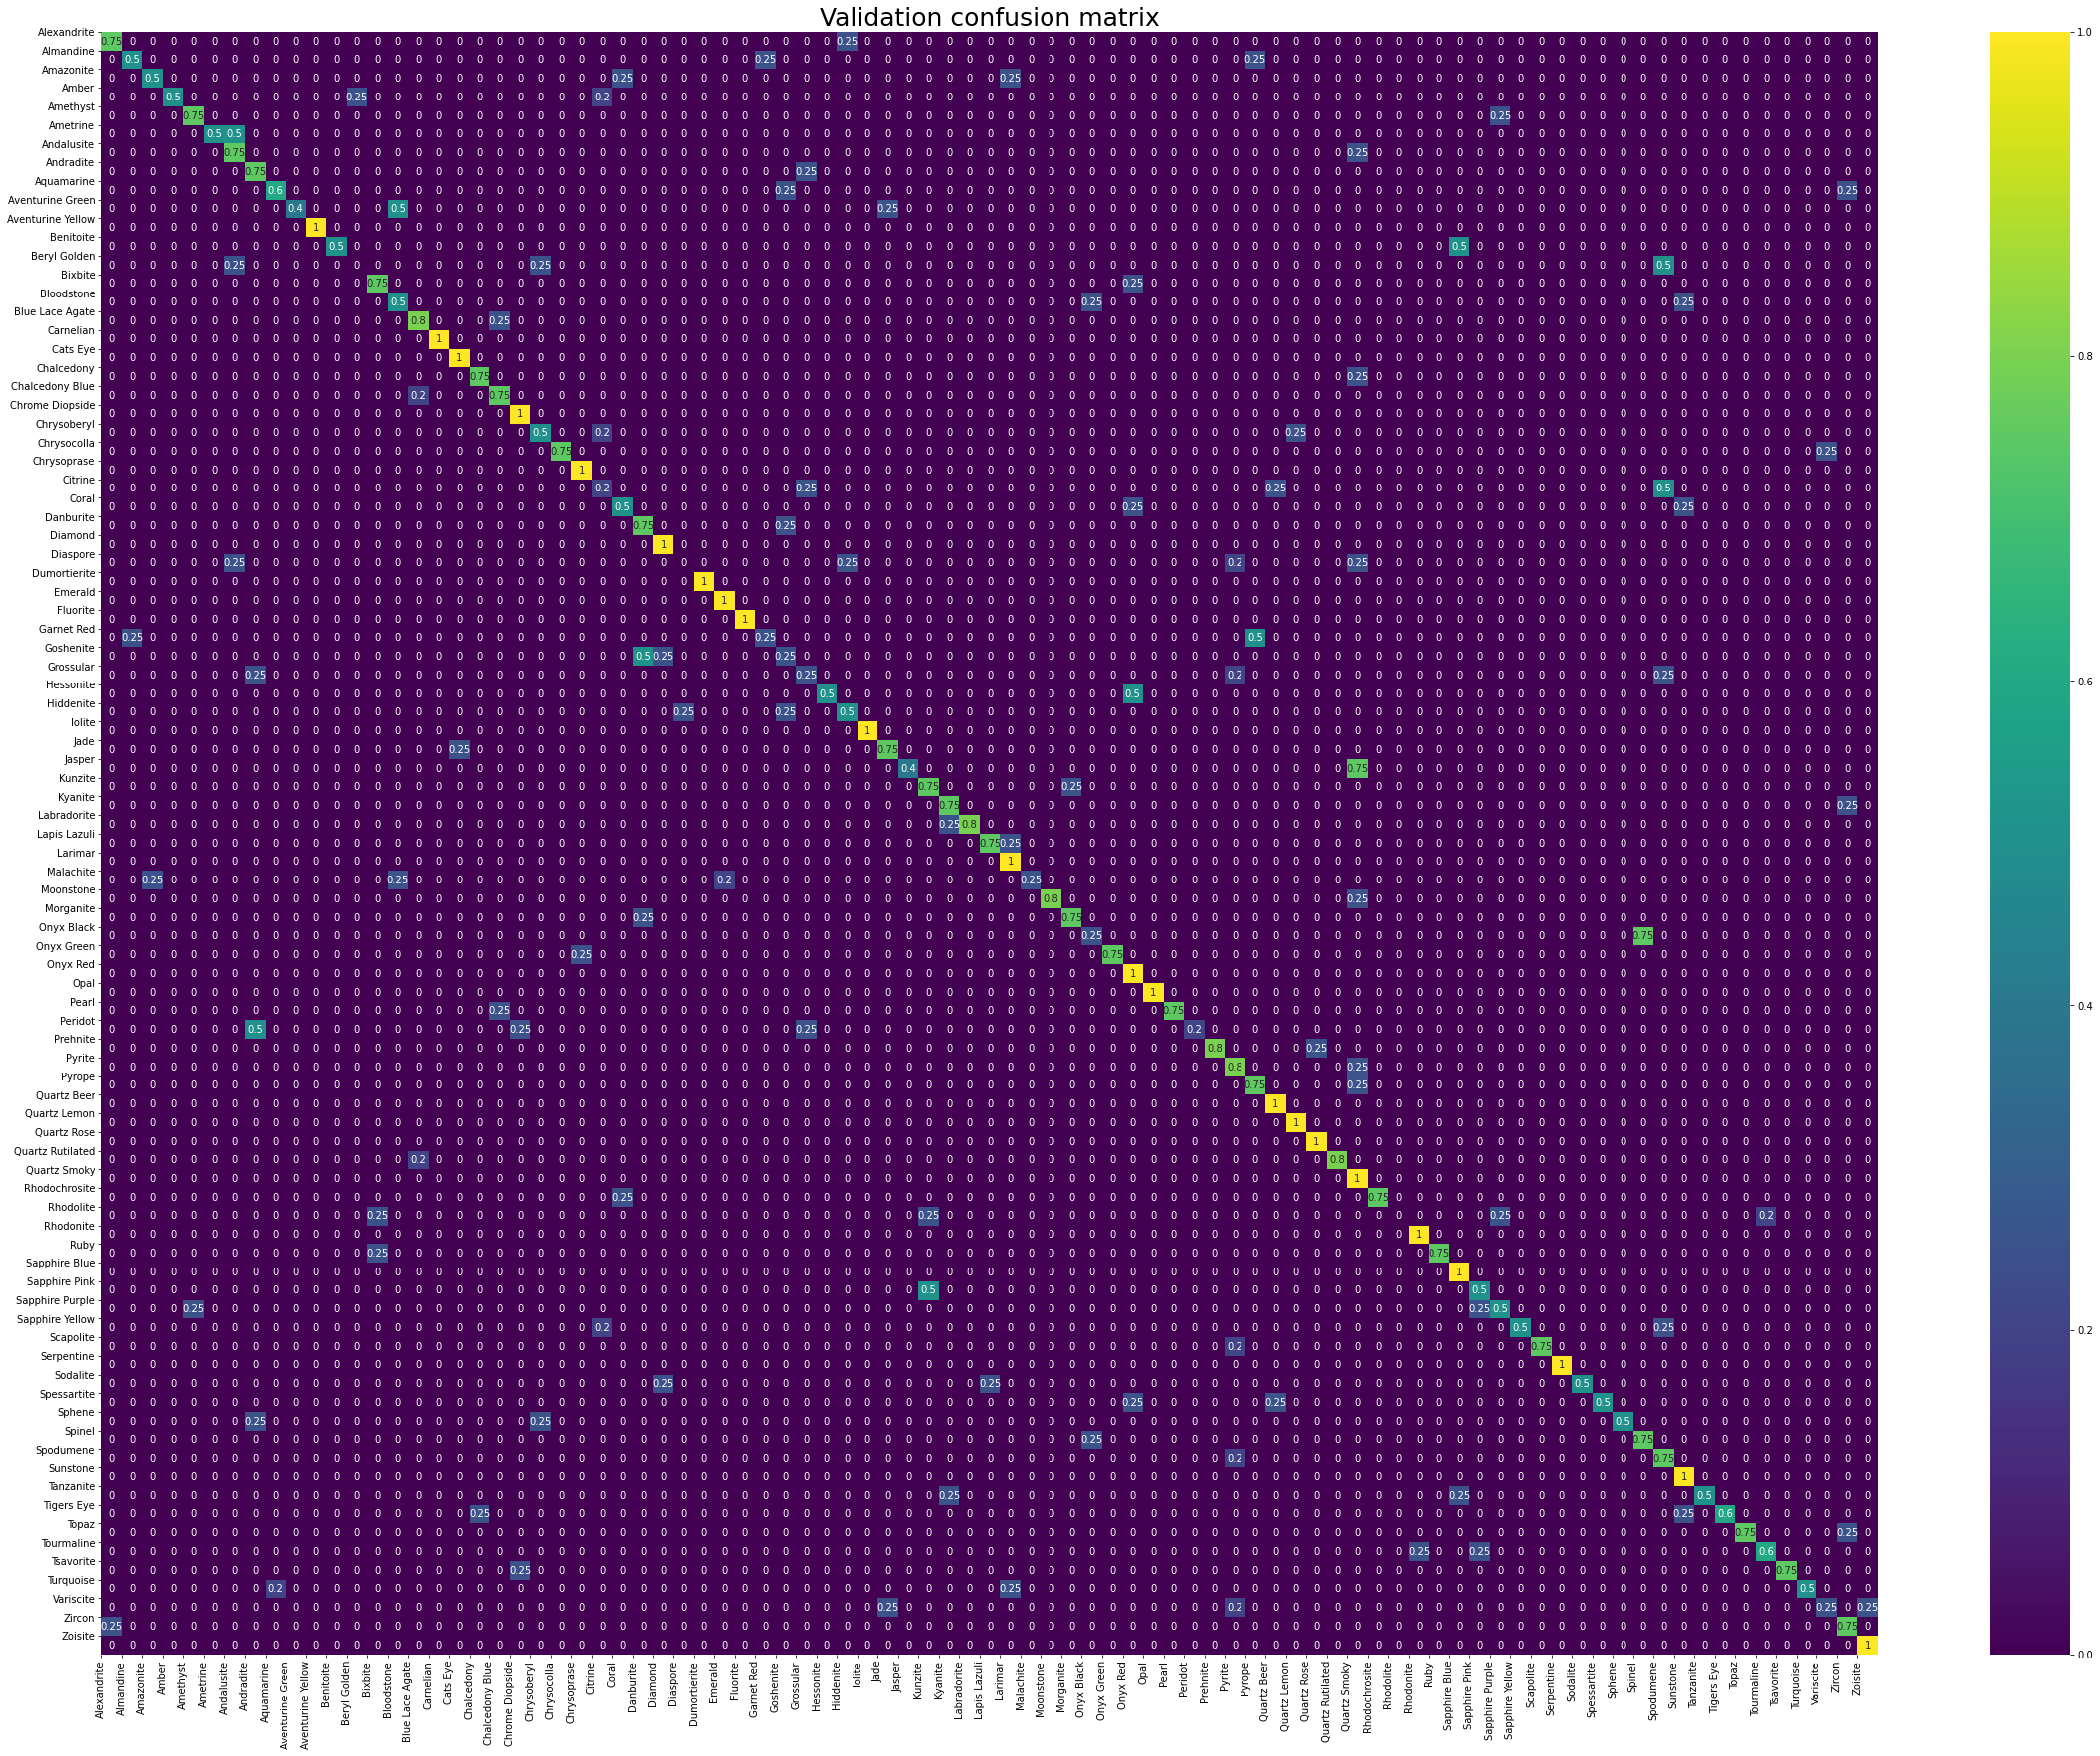

In [41]:
#VALIDATION SET
plot_confusion_matrix(val_data, 'Validation confusion matrix')

Found 2856 images belonging to 87 classes.


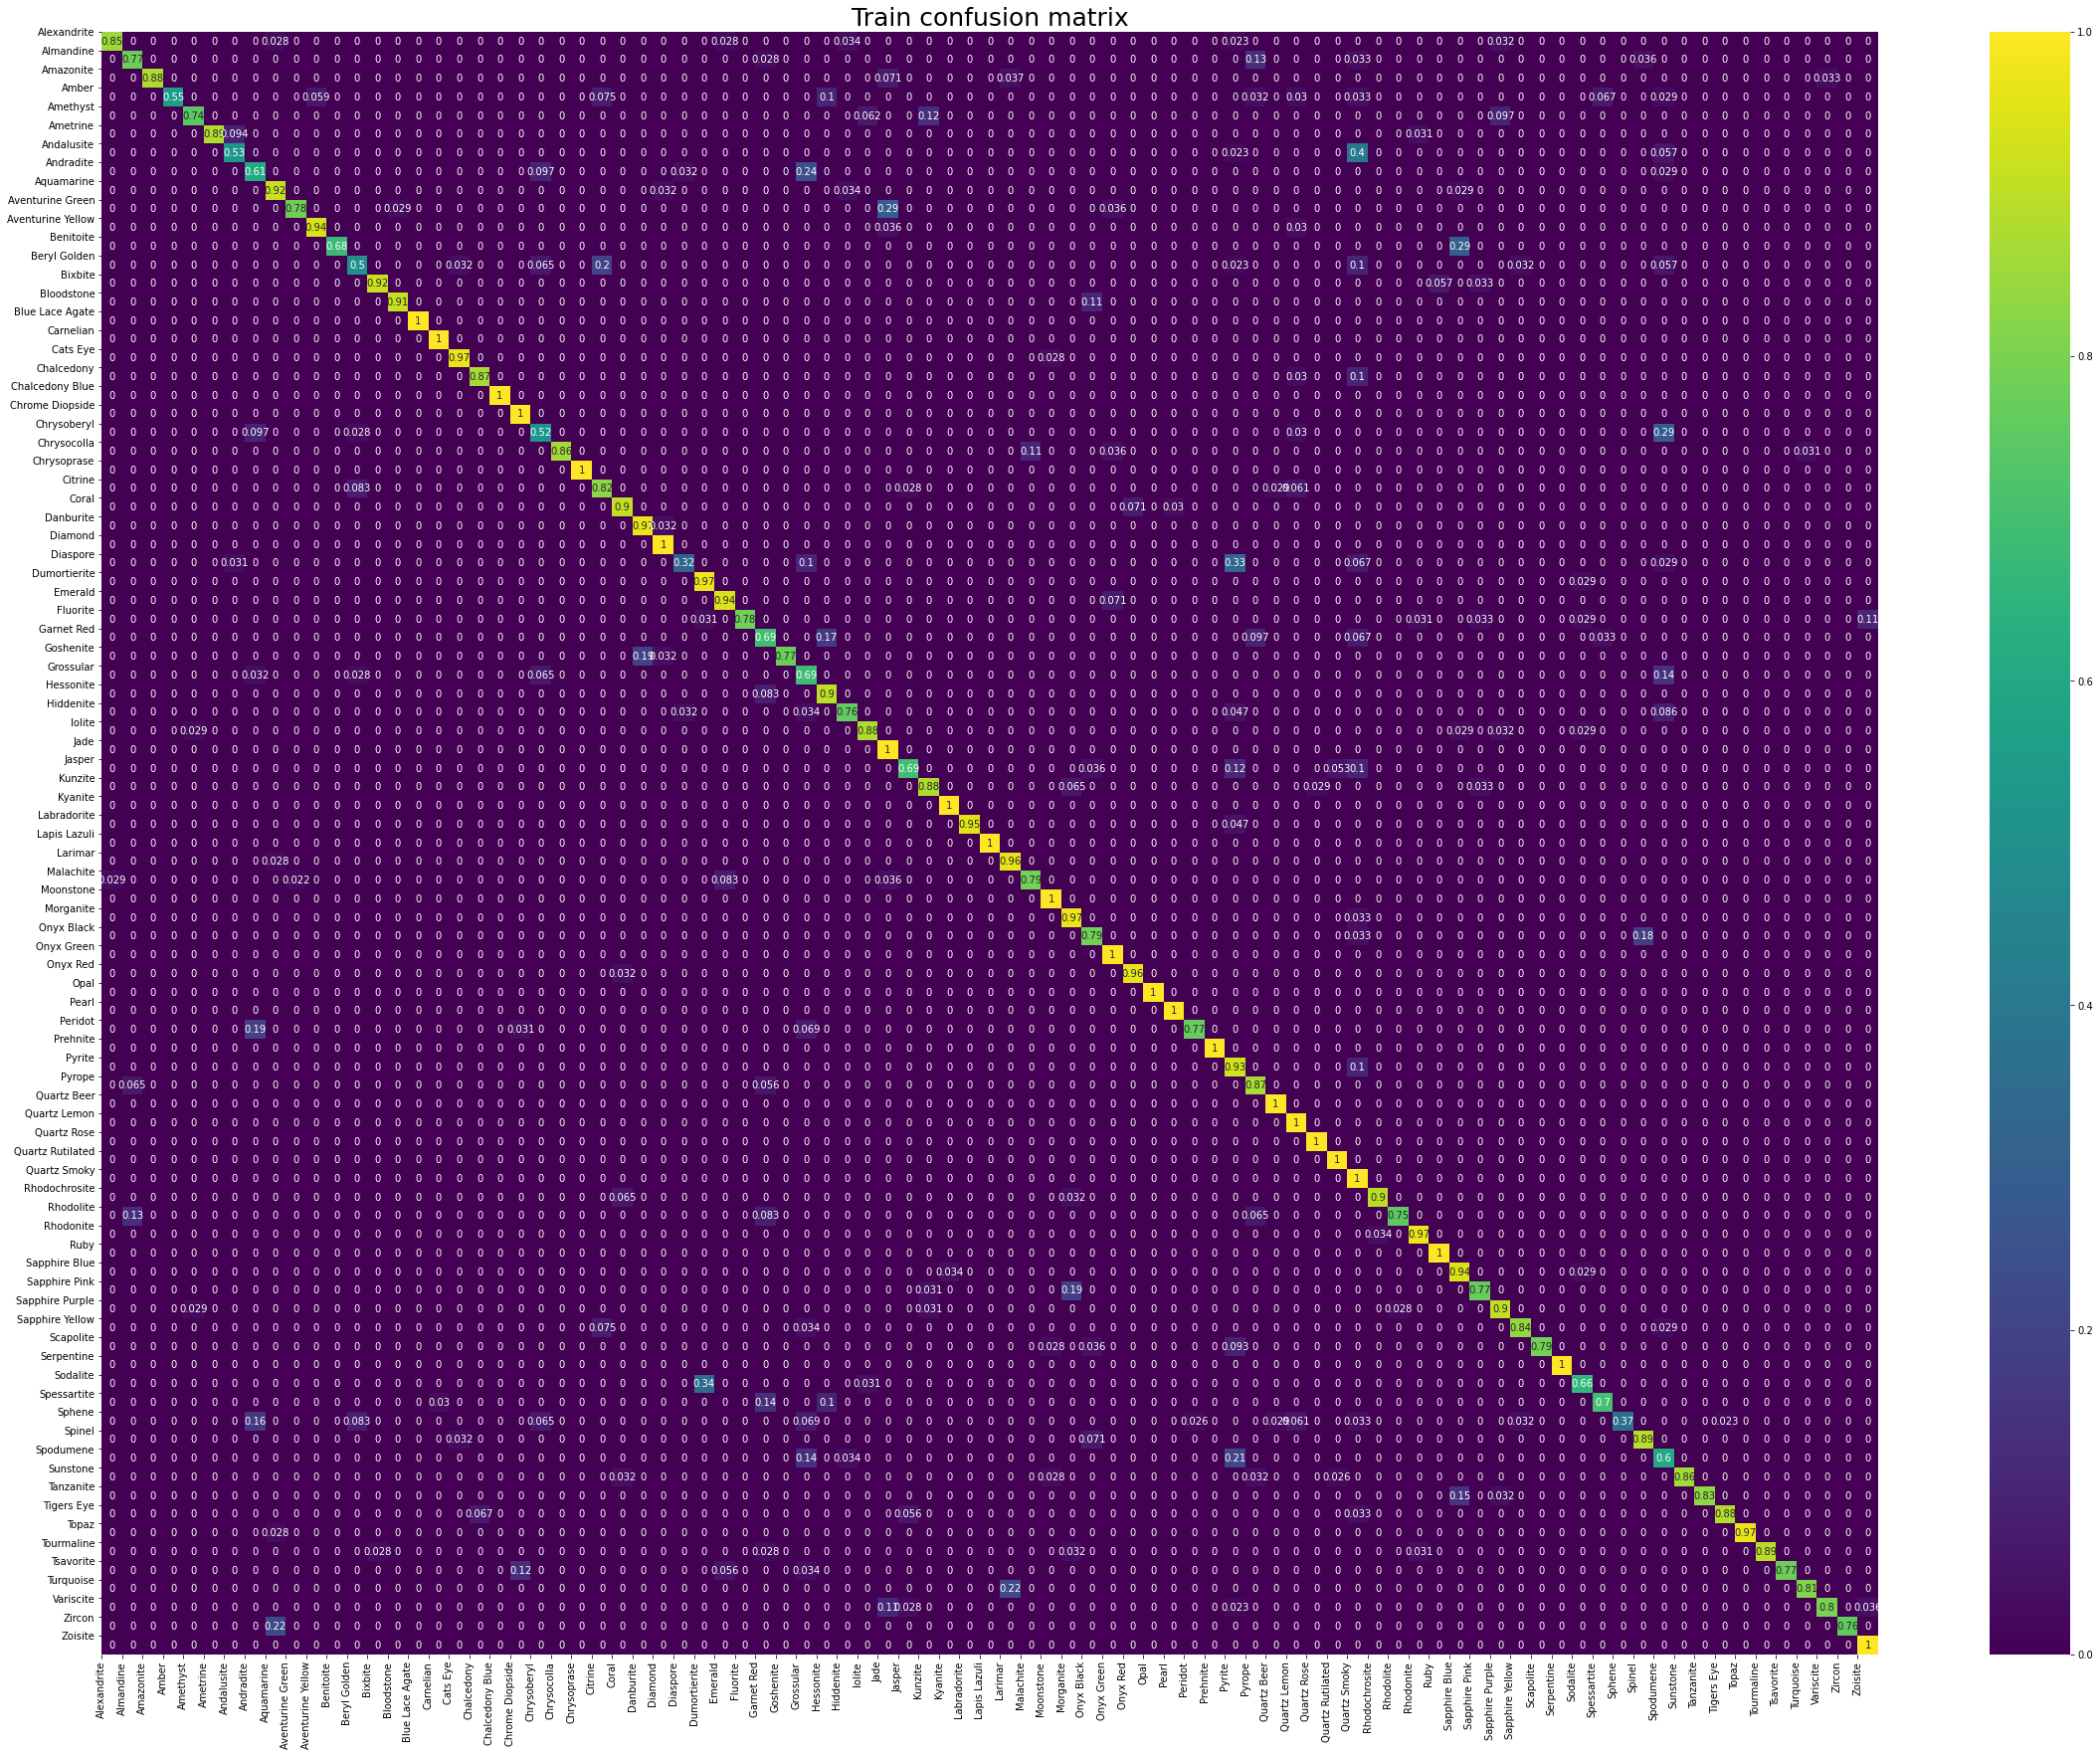

In [48]:
#TRAIN SET
data_gen = image_gen.flow_from_directory(    
    directory=os.path.join(data_dir,'train'),
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)
plot_confusion_matrix(data_gen, 'Train confusion matrix')

## Interpretability

In [49]:
# Prepare data generator to compute score maps
data_gen = image_gen.flow_from_directory(    
    directory=os.path.join(data_dir,'train'),
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)
class_indices = data_gen.class_indices

Found 2856 images belonging to 87 classes.


Text(0.5, 1.0, 'Alexandrite')

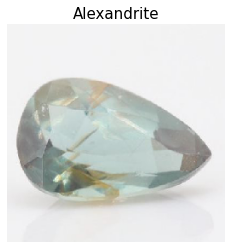

In [132]:
# Load first batch
batch = data_gen[1]
img = batch[0][0]
label_id = np.argmax(batch[1][0])
label_name = [key for key in class_indices if class_indices[key] == label_id][0]

# plot fisrt image
plt.figure(figsize=(5,4))
plot_image(img)
plt.title(label_name, fontsize=15)

In [133]:
#Predicted class
tensor_img = tf.expand_dims(img,axis=0)
logits = model.predict(tensor_img)
probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()
label_id = np.argmax(probs)
label_name = [key for key in class_indices if class_indices[key] == label_id][0]
label_name

'Hiddenite'

In [134]:
# compute Score map
img_score_map = model_inter.get_VarGrad(img=img,
                        baseline='noise',
                        IG_m_steps=70,
                        model=model,
                        n_images=50
                       )
img_score_map = img_score_map.numpy()

Text(0.5, 1.0, 'Hiddenite')

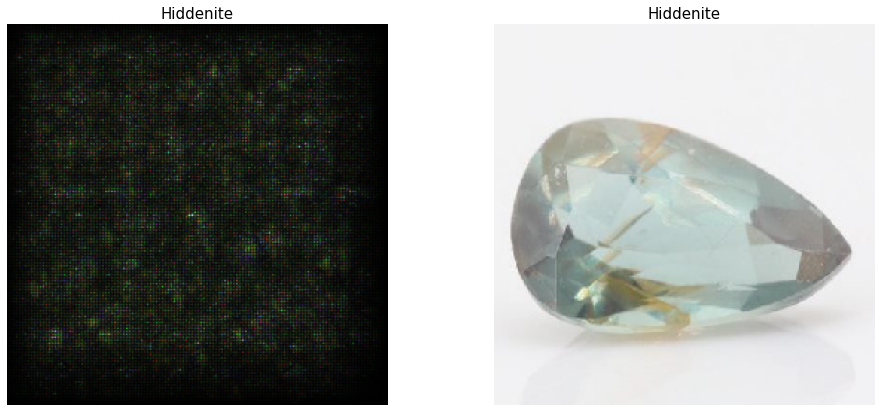

In [135]:
# Normalize score map 
temp_score_map = copy.deepcopy(img_score_map)
#min_vals = temp_score_map.min(axis=(0,1))
#max_vals = temp_score_map.max(axis=(0,1))
min_vals = temp_score_map.min()
max_vals = temp_score_map.max()
temp_score_map = (temp_score_map - min_vals) / (max_vals - min_vals)

#temp_score_map += 0.5

# Plot score map
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plot_image(temp_score_map)
plt.title(label_name, fontsize=15)

# plot fisrt image
plt.subplot(1,2,2)
plot_image(img)
plt.title(label_name, fontsize=15)

In [206]:
val_data = image_gen.flow_from_directory(
    directory=os.path.join(data_dir,'test'),
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)

Found 363 images belonging to 87 classes.


In [207]:
n_batches = int(np.ceil(val_data.n/BATCH_SIZE))
classes_df = pd.DataFrame()

for batch in np.arange(n_batches):
    classes = np.argmax(val_data[batch][1], axis=1)
    temp_df = pd.DataFrame(classes)
    classes_df = classes_df.append(temp_df, ignore_index=True)
classes_df.columns = ['true_class']

#logits and probs
val_logits = model.predict(val_data)
val_probs = tf.keras.activations.softmax(tf.constant(val_logits)).numpy()


classes_df['predicted_class'] = np.argmax(val_probs, axis=1)

In [208]:
confusion_matrix = confusion_matrix(classes_df.true_class.values, 
                                    classes_df.predicted_class.values, 
                                    labels=np.arange(87))

confusion_matrix_norm = confusion_matrix / confusion_matrix.sum(axis=1)

TypeError: 'numpy.ndarray' object is not callable

In [209]:
confusion_matrix_norm

array([[0.75, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]])

<AxesSubplot:>

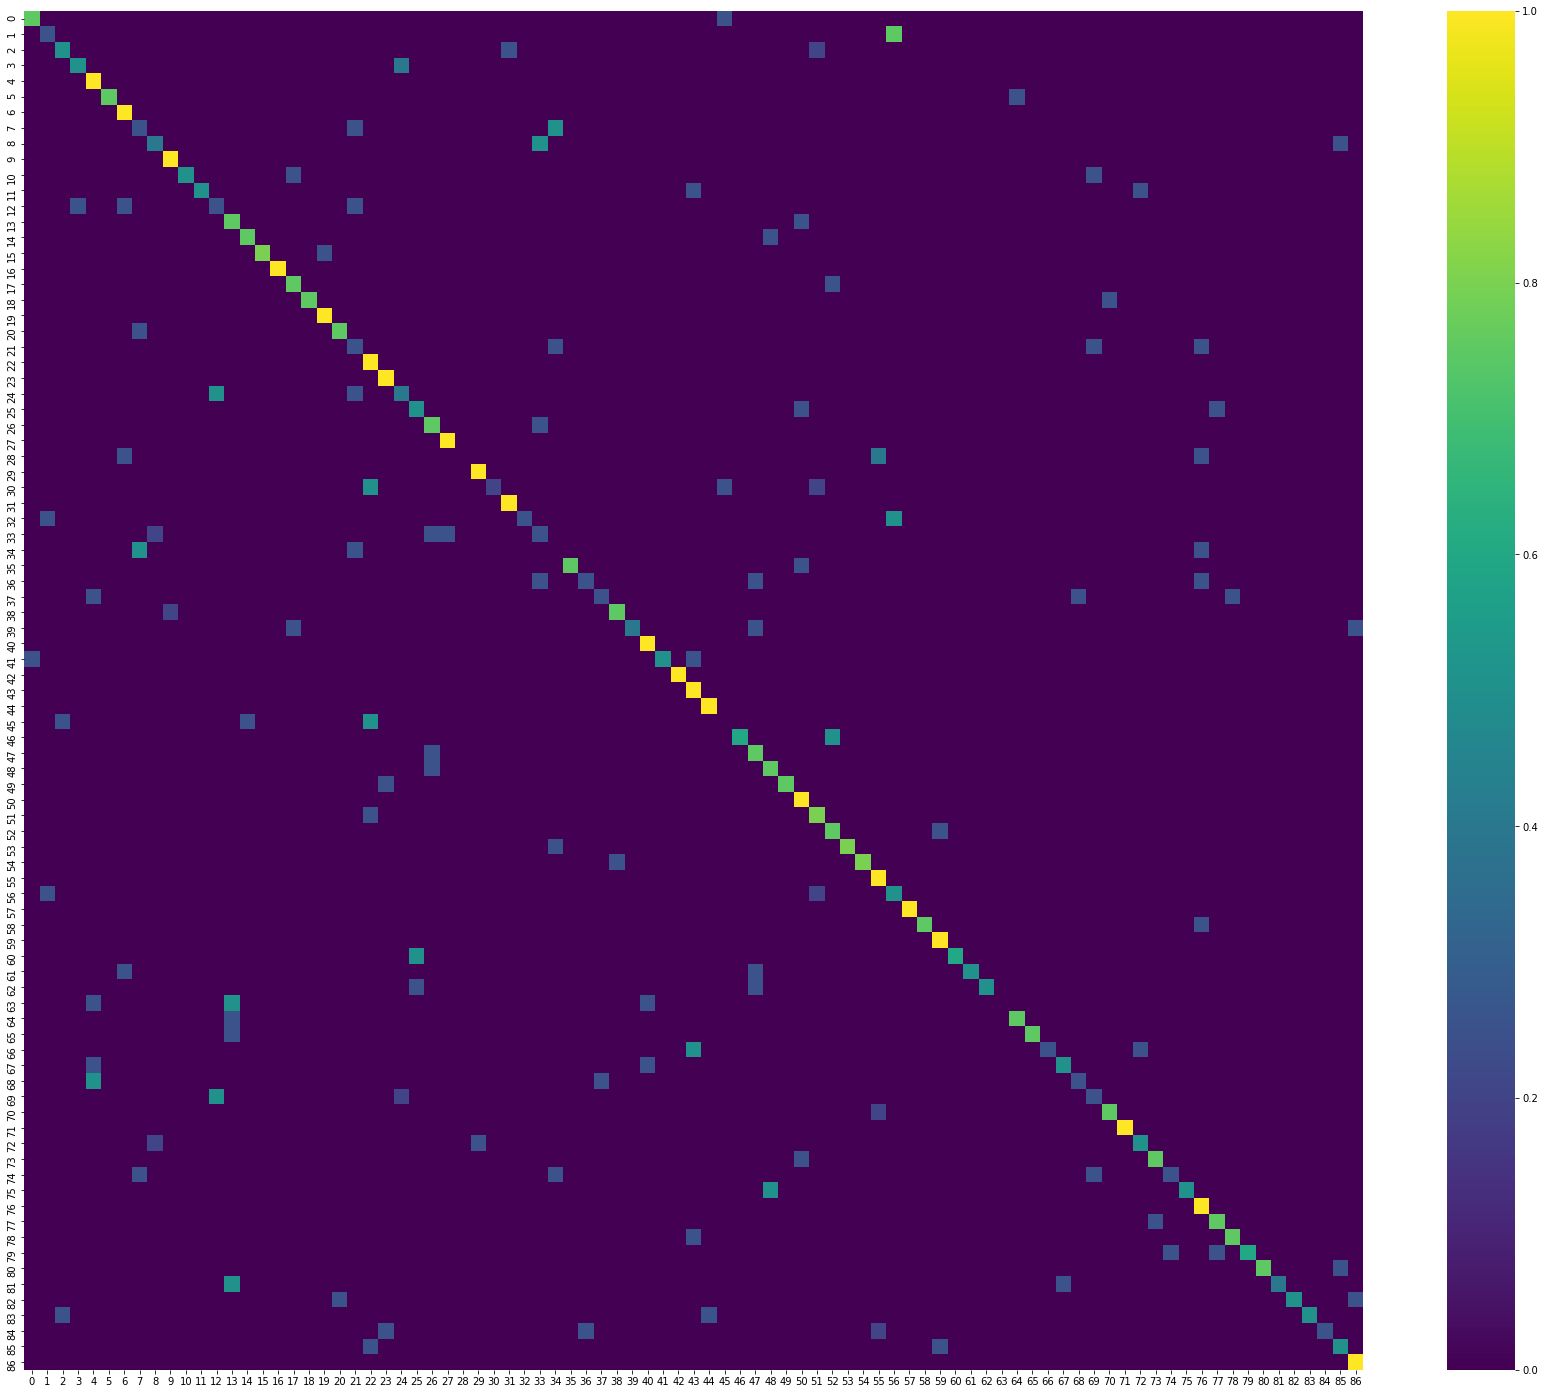

In [210]:
plt.figure(figsize=(30,25))
sns.heatmap(confusion_matrix_norm, cmap='viridis')

In [190]:
train_data = image_gen.flow_from_directory(
    directory=os.path.join(data_dir,'train'),
    target_size=input_shape,
    color_mode='rgb', 
    classes=None,
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    seed=seed,
    save_to_dir=None, 
    save_prefix='', 
    save_format='png',
    follow_links=False, 
    subset=None, 
    interpolation='nearest'
)

Found 2856 images belonging to 87 classes.


In [191]:
n_batches = int(np.ceil(train_data.n/BATCH_SIZE))
classes_df = pd.DataFrame()

for batch in np.arange(n_batches):
    classes = np.argmax(train_data[batch][1], axis=1)
    temp_df = pd.DataFrame(classes)
    classes_df = classes_df.append(temp_df, ignore_index=True)
classes_df.columns = ['true_class']

#logits and probs
train_logits = model.predict(train_data)
train_probs = tf.keras.activations.softmax(tf.constant(train_logits)).numpy()


classes_df['predicted_class'] = np.argmax(train_probs, axis=1)

In [193]:
classes_df

,true_class,predicted_class
0,0,31
1,0,0
2,0,0
3,0,31
4,0,0
...,...,...
2851,86,86
2852,86,86
2853,86,86
2854,86,86


In [200]:
classes_df.true_class.values.shape

(2856,)

In [199]:
classes_df.predicted_class.values.shape

(2856,)

In [205]:
confusion_matrix = confusion_matrix(classes_df['true_class'], 
                                    classes_df['predicted_class'], 
                                    labels=np.arange(87))

#confusion_matrix_norm = confusion_matrix / confusion_matrix.sum(axis=1)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
diag = np.diag(A)

<AxesSubplot:>

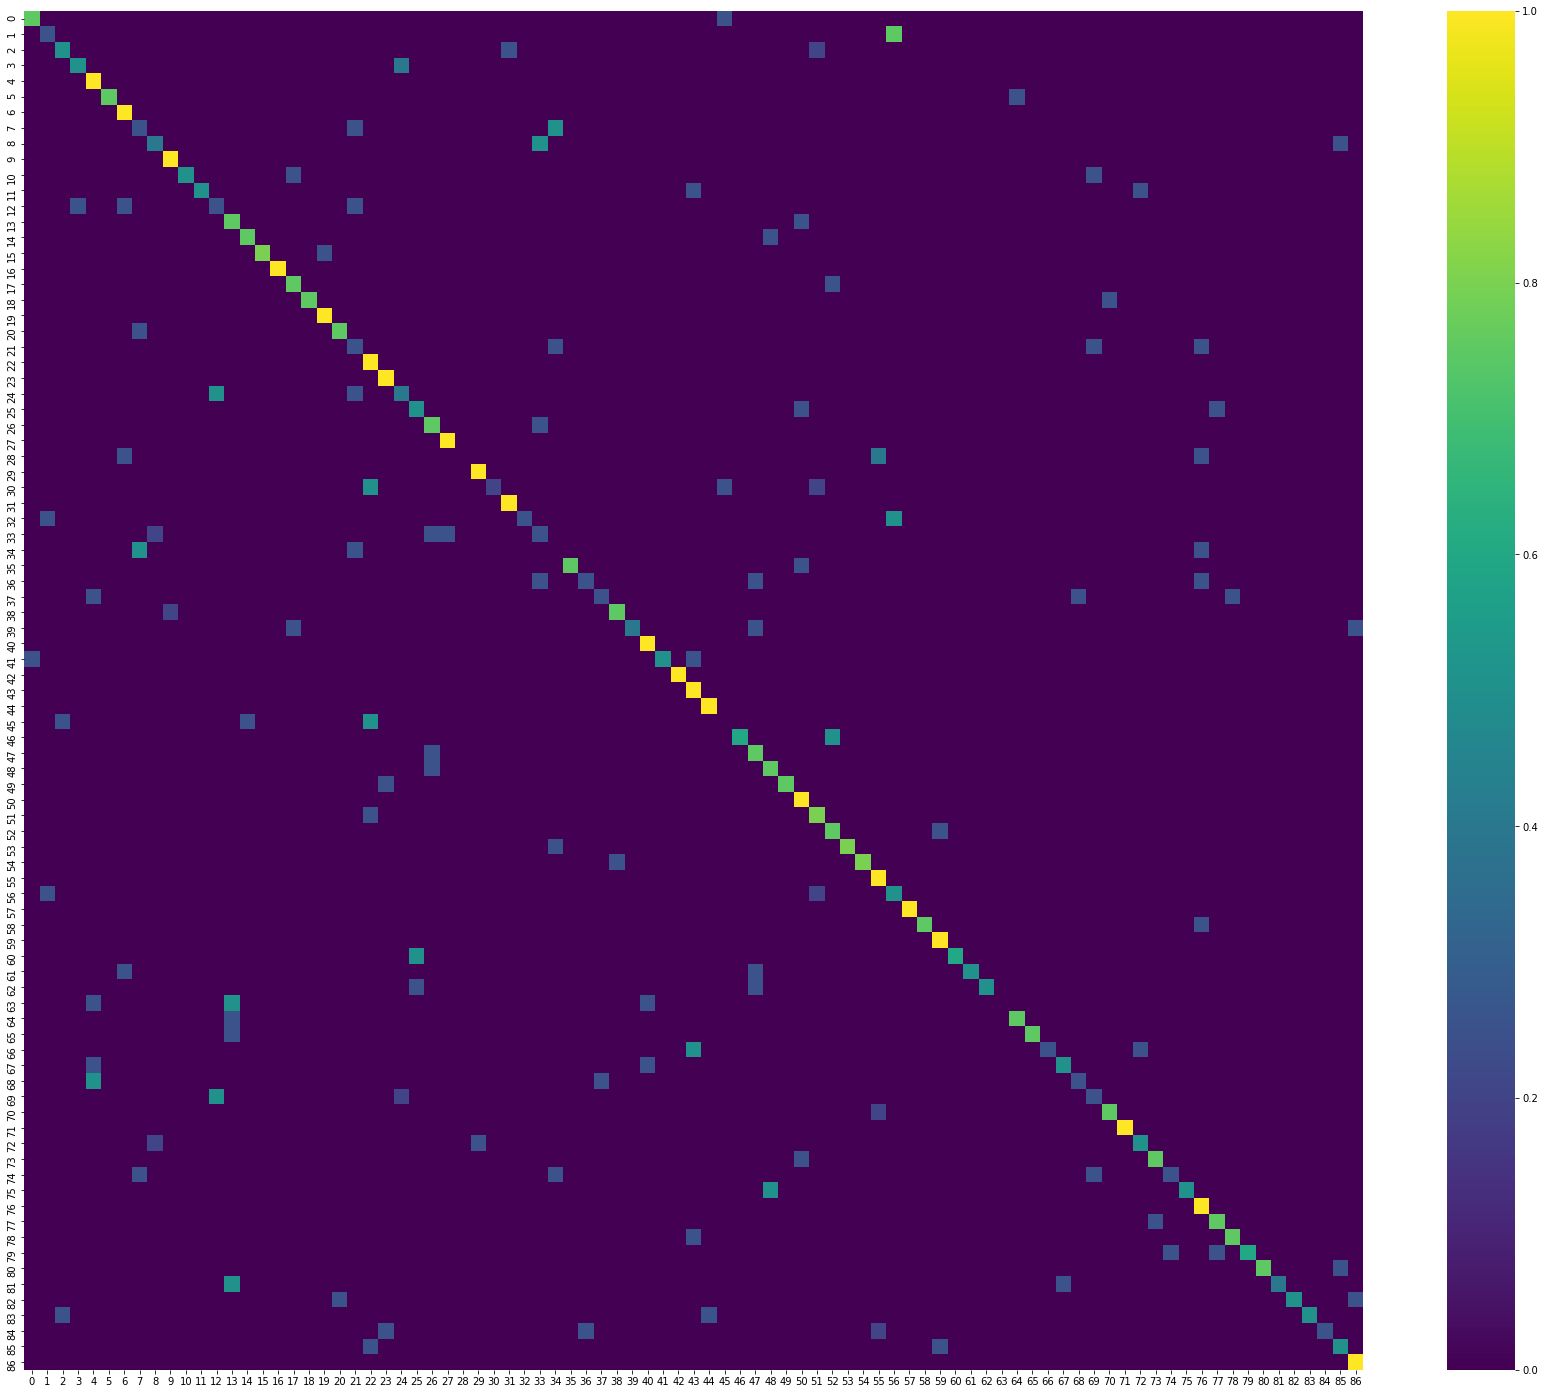

In [188]:
plt.figure(figsize=(30,25))
sns.heatmap(confusion_matrix_norm, cmap='viridis')

In [117]:
val_data[0]

(16, 256, 256, 3)

In [113]:
np.argmax(val_probs, axis=1)

array([ 0,  0, 45,  0, 56,  1, 56, 56, 51,  2,  2, 31,  3, 24, 24,  3,  4,
        4,  4,  4,  5,  5,  5, 64,  6,  6,  6,  6,  7, 34, 34, 21, 85, 33,
        8, 33,  8,  9,  9,  9,  9,  9, 69, 10, 17, 10, 72, 11, 11, 43, 21,
        3, 12,  6, 13, 13, 13, 50, 14, 14, 14, 48, 15, 15, 19, 15, 15, 16,
       16, 16, 16, 17, 17, 17, 52, 70, 18, 18, 18, 19, 19, 19, 19, 20, 20,
        7, 20, 34, 69, 21, 76, 22, 22, 22, 22, 23, 23, 23, 23, 21, 24, 12,
       12, 24, 25, 25, 77, 50, 26, 26, 33, 26, 27, 27, 27, 27, 55,  6, 76,
       55, 29, 29, 29, 29, 51, 22, 30, 45, 22, 31, 31, 31, 31,  1, 56, 56,
       32, 26, 33,  8, 27, 21,  7,  7, 76, 35, 35, 35, 50, 76, 36, 47, 33,
       68, 37,  4, 78, 38, 38, 38,  9, 39, 17, 39, 86, 47, 40, 40, 40, 40,
       41,  0, 41, 43, 42, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44,
       22,  2, 22, 14, 52, 52, 46, 46, 46, 47, 47, 47, 26, 26, 48, 48, 48,
       49, 23, 49, 49, 50, 50, 50, 50, 51, 22, 51, 51, 51, 52, 52, 59, 52,
       53, 34, 53, 53, 53